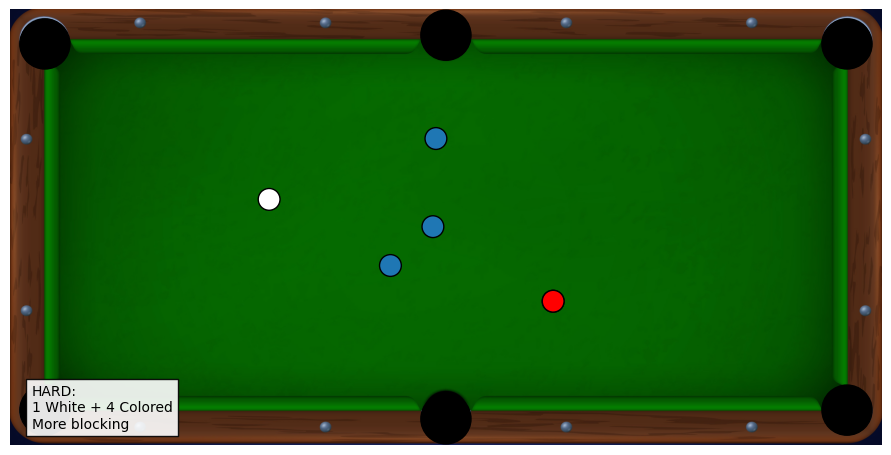

In [4]:
import math
import random
import os
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# =========================
# CONFIG
# =========================
TABLE_W, TABLE_H = 200, 100
BALL_R = 2.5
MAX_CUT_ANGLE = 65

TABLE_IMAGE = "po2ol_table.jpeg"
if not os.path.exists(TABLE_IMAGE):
    raise FileNotFoundError("pool_table.jpeg not found")

POCKETS = {
    "TL": (8, 8), "TM": (100, 6), "TR": (192, 8),
    "BL": (8, 92), "BM": (100, 94), "BR": (192, 92)
}

SCENARIO = {"EASY":1, "NORMAL":2, "HARD":3, "CUSTOM":4}

SCENARIO_TEXT = {
    1: "EASY:\nClick WHITE → Click COLORED",
    2: "NORMAL:\n1 White + 3 Colored\nClick a colored ball",
    3: "HARD:\n1 White + 4 Colored\nMore blocking",
    4: "CUSTOM:\nClick WHITE\nPlace COLORED (max 4)\nClick colored to predict"
}

# =========================
# GEOMETRY
# =========================
def dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def angle_between(v1, v2):
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    m1 = math.hypot(*v1)
    m2 = math.hypot(*v2)
    if m1 == 0 or m2 == 0:
        return 180
    return math.degrees(math.acos(max(-1, min(1, dot/(m1*m2)))))

def segment_hits_ball(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    lab = dist(a, b)
    if lab == 0:
        return False
    t = ((cx-ax)*(bx-ax) + (cy-ay)*(by-ay)) / lab**2
    t = max(0, min(1, t))
    px = ax + t*(bx-ax)
    py = ay + t*(by-ay)
    return dist((px, py), c) < BALL_R*2

# =========================
# SHOT LOGIC
# =========================
def compute_shots(white, target, blockers):
    shots = []
    for pname, pocket in POCKETS.items():
        vx, vy = pocket[0]-target[0], pocket[1]-target[1]
        d = math.hypot(vx, vy)
        if d == 0:
            continue

        ghost = (
            target[0] - vx/d * BALL_R*2,
            target[1] - vy/d * BALL_R*2
        )

        cut = angle_between(
            (ghost[0]-white[0], ghost[1]-white[1]),
            (pocket[0]-target[0], pocket[1]-target[1])
        )

        if cut > MAX_CUT_ANGLE:
            continue

        if any(
            segment_hits_ball(white, ghost, b) or
            segment_hits_ball(target, pocket, b)
            for b in blockers
        ):
            continue

        d1 = dist(white, ghost)
        d2 = dist(target, pocket)

        power = min(100, int((d1 + d2) * 0.6))
        angle = angle_between(
            (ghost[0]-white[0], ghost[1]-white[1]),
            (1, 0)
        )

        score = cut + d1*0.02
        shots.append({
            "score": score,
            "path": [white, ghost, pocket],
            "pocket": pname,
            "angle": angle,
            "power": power
        })

    return sorted(shots, key=lambda s: s["score"])[:2]

# =========================
# STATE
# =========================
white = None
colored = []
selected = None
current_scenario = None

# =========================
# TKINTER
# =========================
root = tk.Tk()
root.title("Pool AI – Realistic Trainer")
root.geometry("1250x680")

fig, ax = plt.subplots(figsize=(9.5,5))
table_img = plt.imread(TABLE_IMAGE)

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# =========================
# DRAW
# =========================
def draw_ball(pos, color):
    ax.add_patch(plt.Circle(pos, BALL_R, fc=color, ec="black", zorder=5))

def redraw():
    ax.clear()
    ax.set_xlim(0, TABLE_W)
    ax.set_ylim(TABLE_H, 0)
    ax.set_aspect("equal")
    ax.axis("off")

    ax.imshow(table_img, extent=[0,TABLE_W,TABLE_H,0], zorder=0)

    for p in POCKETS.values():
        ax.add_patch(plt.Circle(p, BALL_R*2.3, color="black", zorder=3))

    if white:
        draw_ball(white, "white")

    for b in colored:
        draw_ball(b, "#1f77b4")

    if selected:
        draw_ball(selected, "red")

    if white and selected:
        shots = compute_shots(white, selected, [b for b in colored if b != selected])
        colors = ["red", "orange"]

        for i, s in enumerate(shots):
            xs = [p[0] for p in s["path"]]
            ys = [p[1] for p in s["path"]]
            ax.plot(xs, ys, color=colors[i], linewidth=4)

            ax.text(
                white[0]+5,
                white[1]+10+i*8,
                f"BEST {i+1}: {s['pocket']}\n"
                f"Angle: {s['angle']:.1f}°\n"
                f"Power: {s['power']}%",
                fontsize=9,
                bbox=dict(facecolor="white", alpha=0.85)
            )

    if current_scenario:
        ax.text(5, 96, SCENARIO_TEXT[current_scenario],
                bbox=dict(facecolor="white", alpha=0.9))

    canvas.draw()

# =========================
# CLICK HANDLER (FIXED CUSTOM)
# =========================
def on_click(event):
    global white, selected
    if event.inaxes != ax or not current_scenario:
        return

    pos = (event.xdata, event.ydata)

    if current_scenario == SCENARIO["EASY"]:
        if not white:
            white = pos
        else:
            selected = pos

    elif current_scenario in (SCENARIO["NORMAL"], SCENARIO["HARD"]):
        for b in colored:
            if dist(pos, b) < BALL_R*2:
                selected = b

    elif current_scenario == SCENARIO["CUSTOM"]:
        if not white:
            white = pos
        elif len(colored) < 4:
            colored.append(pos)
        else:
            for b in colored:
                if dist(pos, b) < BALL_R*2:
                    selected = b

    redraw()

canvas.mpl_connect("button_press_event", on_click)

# =========================
# SCENARIO SETUP
# =========================
def setup_scenario(s):
    global white, colored, selected, current_scenario
    white, colored, selected = None, [], None
    current_scenario = s

    if s in (SCENARIO["NORMAL"], SCENARIO["HARD"]):
        white = (random.uniform(40,160), random.uniform(25,75))
        n = 3 if s == SCENARIO["NORMAL"] else 4
        for _ in range(n):
            colored.append((random.uniform(40,160), random.uniform(25,75)))

    redraw()

# =========================
# CONTROL PANEL
# =========================
panel = tk.Frame(root, padx=10)
panel.pack(side=tk.RIGHT, fill=tk.Y)

tk.Label(panel, text="SCENARIO", font=("Arial",14,"bold")).pack(pady=10)

for name, val in SCENARIO.items():
    ttk.Button(panel, text=name,
               command=lambda v=val: setup_scenario(v)).pack(fill="x", pady=4)

redraw()
root.mainloop()
